# Stroke Prediction

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
# Check GPU 
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices())

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Dataset

In [3]:
# Loading the Dataset
df = pd.read_csv("C:/Users/daxab/py projects/stroke_prediction/df/stroke_risk_dataset_v2.csv") 

# Display few rows
df.head()

,age,gender,chest_pain,high_blood_pressure,irregular_heartbeat,shortness_of_breath,fatigue_weakness,dizziness,swelling_edema,neck_jaw_pain,excessive_sweating,persistent_cough,nausea_vomiting,chest_discomfort,cold_hands_feet,snoring_sleep_apnea,anxiety_doom,stroke_risk_percentage,at_risk
0,22,Male,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,33.3,0
1,52,Male,0,1,1,0,0,0,0,0,0,0,0,0,1,1,0,100.0,1
2,63,Female,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,100.0,1
3,41,Male,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,44.5,0
4,53,Male,0,0,0,0,0,1,1,0,0,0,1,0,1,0,0,84.8,1


In [4]:
df.columns

Index(['age', 'gender', 'chest_pain', 'high_blood_pressure',
       'irregular_heartbeat', 'shortness_of_breath', 'fatigue_weakness',
       'dizziness', 'swelling_edema', 'neck_jaw_pain', 'excessive_sweating',
       'persistent_cough', 'nausea_vomiting', 'chest_discomfort',
       'cold_hands_feet', 'snoring_sleep_apnea', 'anxiety_doom',
       'stroke_risk_percentage', 'at_risk'],
      dtype='object')

In [5]:
df.shape

(35000, 19)

Checking and Handling Missing Values

In [6]:
# Check for missing values
print(df.isnull().sum())

age                       0
gender                    0
chest_pain                0
high_blood_pressure       0
irregular_heartbeat       0
shortness_of_breath       0
fatigue_weakness          0
dizziness                 0
swelling_edema            0
neck_jaw_pain             0
excessive_sweating        0
persistent_cough          0
nausea_vomiting           0
chest_discomfort          0
cold_hands_feet           0
snoring_sleep_apnea       0
anxiety_doom              0
stroke_risk_percentage    0
at_risk                   0
dtype: int64


Checking Dataset Balance

In [7]:
# Check target distribution
print(df['at_risk'].value_counts())

at_risk
0    22113
1    12887
Name: count, dtype: int64


Countplot

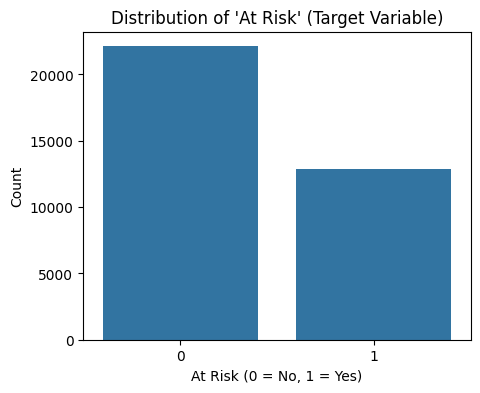

In [8]:
# Plot target distribution
plt.figure(figsize=(5,4))
sns.countplot(x='at_risk', data=df)
plt.title("Distribution of 'At Risk' (Target Variable)")
plt.xlabel("At Risk (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

In [9]:
# All columns into array for countplot
categorical_cols = [
    'age', 'gender', 'chest_pain', 'high_blood_pressure',
       'irregular_heartbeat', 'shortness_of_breath', 'fatigue_weakness',
       'dizziness', 'swelling_edema', 'neck_jaw_pain', 'excessive_sweating',
       'persistent_cough', 'nausea_vomiting', 'chest_discomfort',
       'cold_hands_feet', 'snoring_sleep_apnea', 'anxiety_doom'
]

In [10]:
# Define number of columns and compute rows dynamically
n_cols = 3
n_rows = math.ceil(len(categorical_cols) / n_cols)

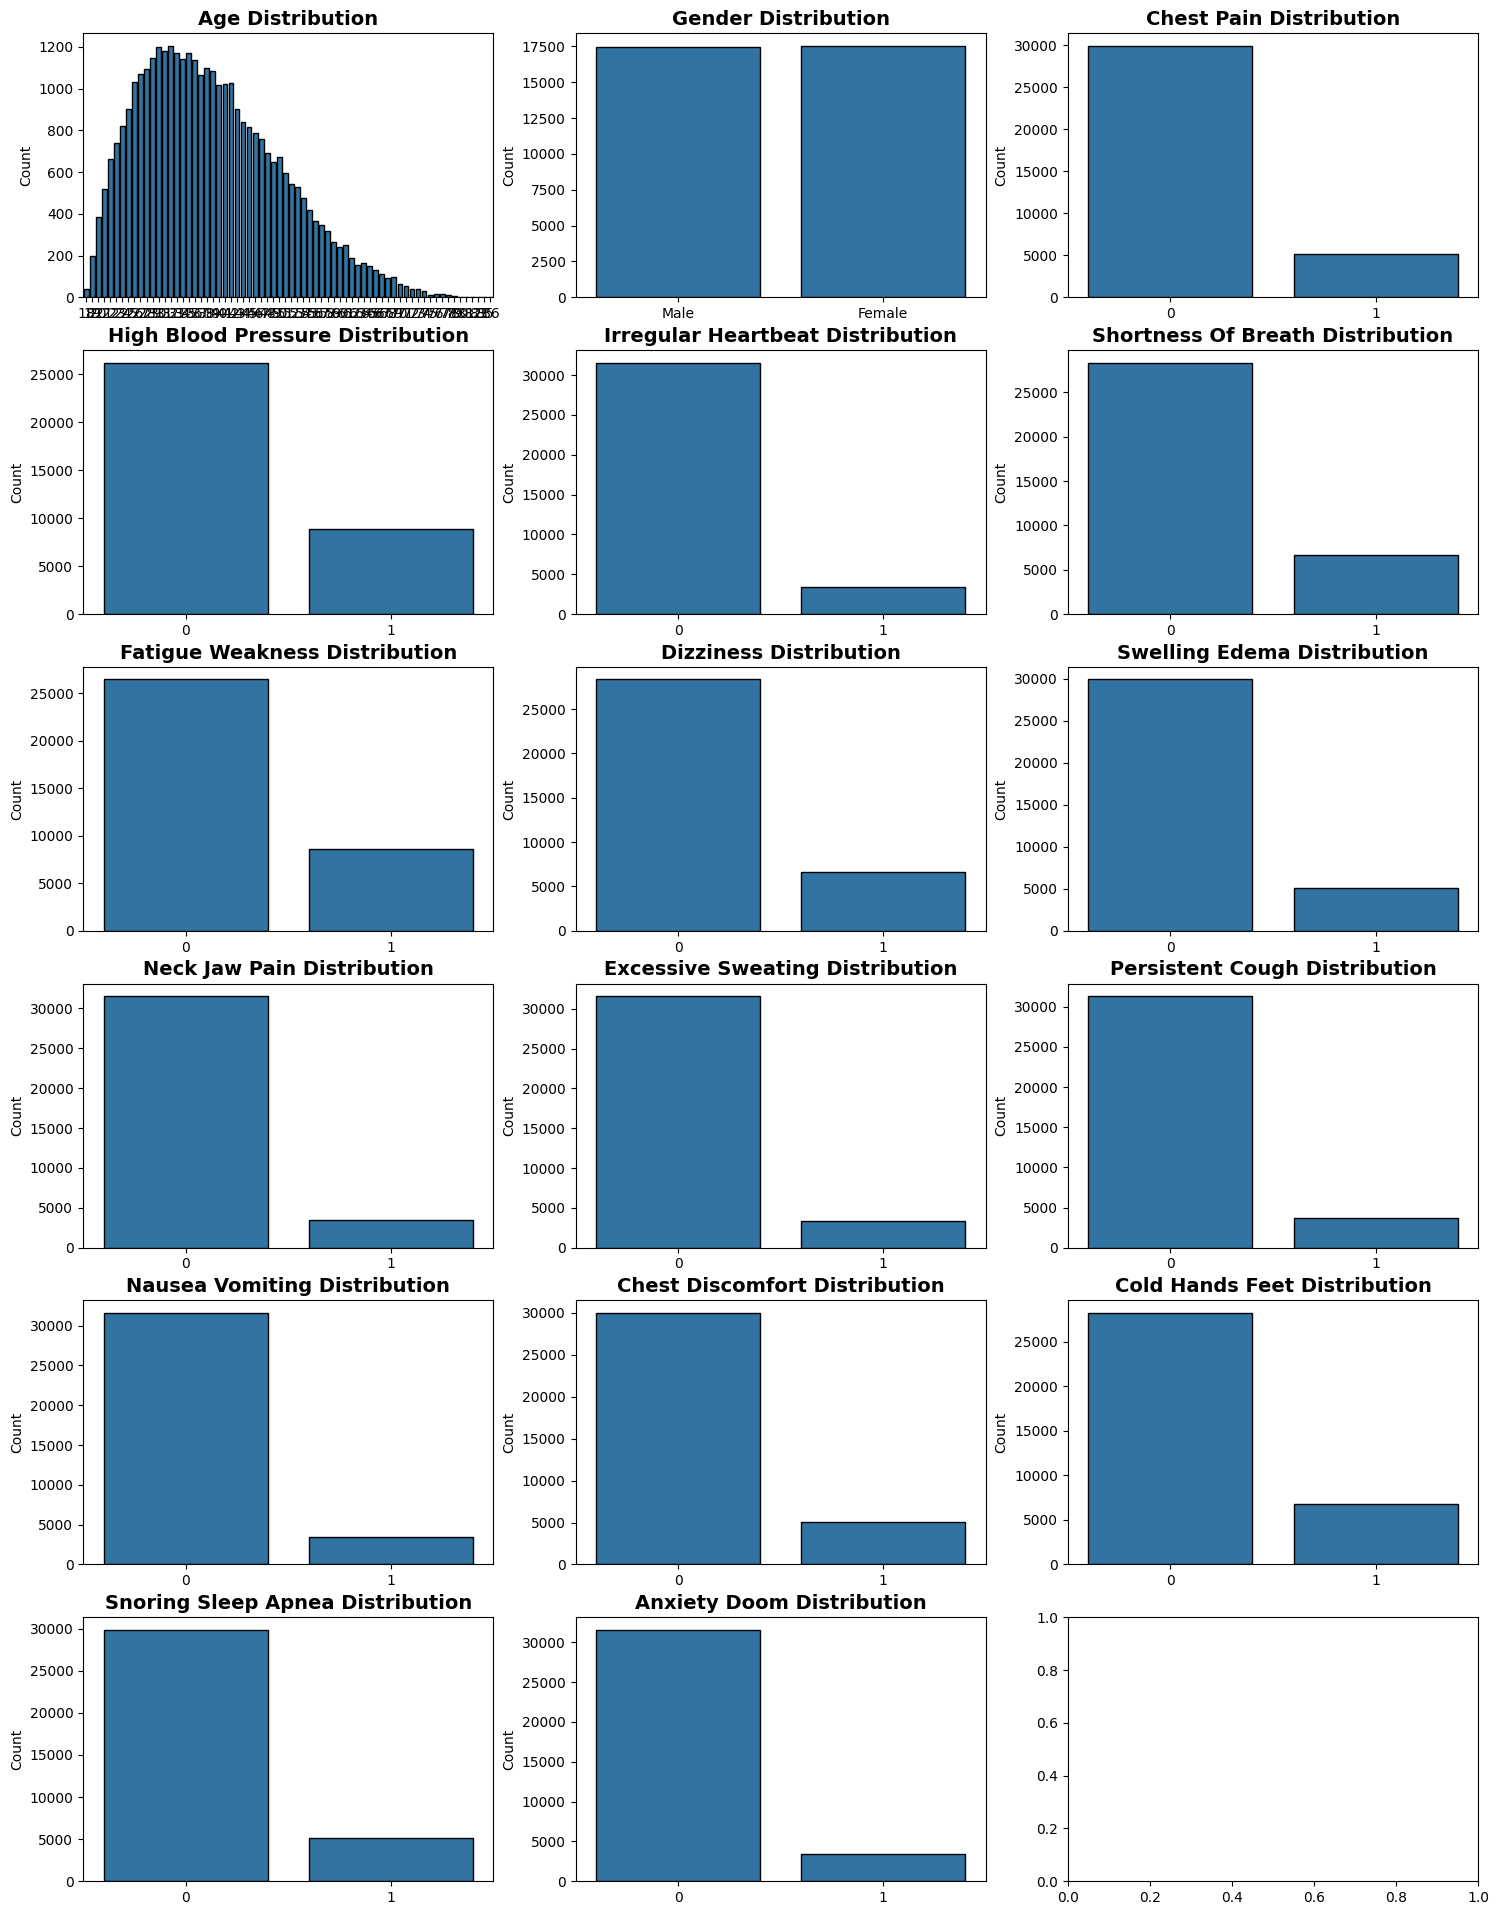

In [11]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))
axes = axes.flatten()

# Looping every column to countplot
for i, col in enumerate(categorical_cols):
    sns.countplot(x=df[col], edgecolor='black', ax=axes[i])
    axes[i].set_title(f'{col.replace("_", " ").title()} Distribution', fontsize=14, fontweight='bold')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=0)

In [12]:
# Display
fig.suptitle('Categorical Feature Distributions', fontsize=18, fontweight='bold', y=1.02)
fig.tight_layout(pad=3.0, rect=[0, 0, 1, 0.97])
plt.show()

Encoding Categorical Values to Numerical

In [13]:
# Make a copy to avoid altering the original DataFrame
df2 = df.copy()

In [14]:
# Automatically detect and encode any non-numeric columns
for col in df2.columns:
    if df2[col].dtype == 'object':
        le = LabelEncoder()
        df2[col] = le.fit_transform(df2[col])
        print(f"Encoded column: {col}")

# Only Gender Column has catergorical values

Encoded column: gender


Correlation Heatmap

In [15]:
# Compute correlation matrix
corr_matrix = df2.corr()

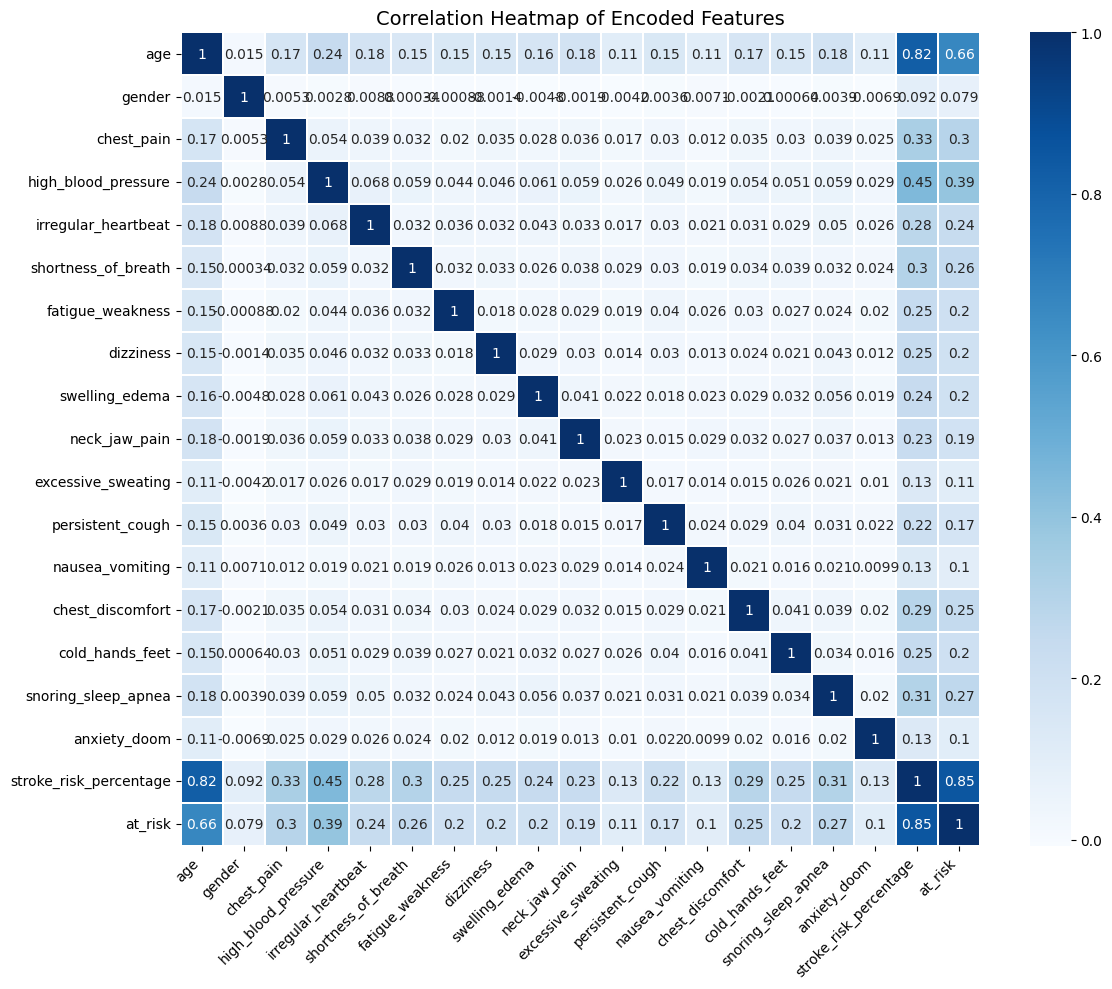

In [16]:
# Plot correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='Blues', linewidths=0.3)
plt.title('Correlation Heatmap of Encoded Features', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Defining Features (X) and Target (y)

In [17]:
# Select features (symptoms + age)
feature_cols = [
    'age', 'gender', 'chest_pain', 'high_blood_pressure',
       'irregular_heartbeat', 'shortness_of_breath', 'fatigue_weakness',
       'dizziness', 'swelling_edema', 'neck_jaw_pain', 'excessive_sweating',
       'persistent_cough', 'nausea_vomiting', 'chest_discomfort',
       'cold_hands_feet', 'snoring_sleep_apnea', 'anxiety_doom'
]

In [18]:
# Initializing
X = df2[feature_cols]
y = df2['at_risk']

Train-Test Split

In [19]:
# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

Scaling Features

In [20]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# First Model - Logistic Regression

In [21]:
# Train Logistic Regression model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000)

In [22]:
# Predict on test data
y_pred_log = log_reg.predict(X_test_scaled)

In [23]:
# Evaluate
acc_log = accuracy_score(y_test, y_pred_log)
print("Logistic Regression Accuracy:", round(acc_log, 4))
print("\nClassification Report (Logistic Regression):")
print(classification_report(y_test, y_pred_log))

Logistic Regression Accuracy: 0.9797

Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      4423
           1       0.97      0.98      0.97      2577

    accuracy                           0.98      7000
   macro avg       0.98      0.98      0.98      7000
weighted avg       0.98      0.98      0.98      7000



In [24]:
# Standard Deviation
# Performing 5-fold cross-validation
log_reg_scores = cross_val_score(log_reg, X_train, y_train, cv=5, scoring='accuracy')

In [25]:
# Compute mean and standard deviation
log_reg_mean = log_reg_scores.mean()
log_reg_std = log_reg_scores.std()

In [26]:
# Results of Standard Deviation
print("Logistic Regression Cross-Validation Results:")
print(f"Accuracy Scores: {log_reg_scores}")
print(f"Mean Accuracy: {log_reg_mean:.4f}")
print(f"Standard Deviation: {log_reg_std:.4f}")

Logistic Regression Cross-Validation Results:
Accuracy Scores: [0.98125    0.98142857 0.98303571 0.97928571 0.98267857]
Mean Accuracy: 0.9815
Standard Deviation: 0.0013


In [27]:
# Confusion matrix for Logistic Regression
cm_log = confusion_matrix(y_test, y_pred_log)
print("\nConfusion Matrix:\n", cm_log)


Confusion Matrix:
 [[4342   81]
 [  61 2516]]


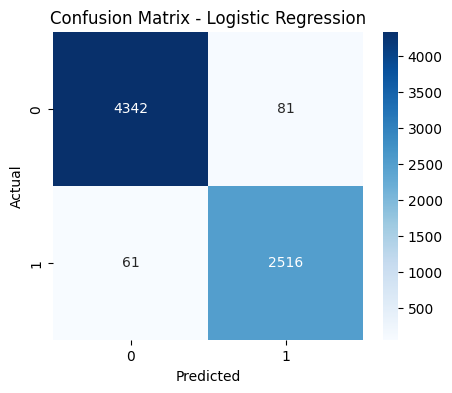

In [28]:
plt.figure(figsize=(5,4))
sns.heatmap(cm_log, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Second Model - SVM

In [29]:
# Train SVM (RBF kernel by default)
svm_model = SVC(kernel='rbf', probability=True)
svm_model.fit(X_train_scaled, y_train)

SVC(probability=True)

In [30]:
# Predict on test data
y_pred_svm = svm_model.predict(X_test_scaled)

In [31]:
# Evaluate
acc_svm = accuracy_score(y_test, y_pred_svm)
print("SVM Accuracy:", round(acc_svm, 4))
print("\nClassification Report (SVM):")
print(classification_report(y_test, y_pred_svm))

SVM Accuracy: 0.9876

Classification Report (SVM):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4423
           1       0.98      0.98      0.98      2577

    accuracy                           0.99      7000
   macro avg       0.99      0.99      0.99      7000
weighted avg       0.99      0.99      0.99      7000



In [32]:
# Standard Deviation
# Perform 5-fold cross-validation
svm_scores = cross_val_score(svm_model, X_train, y_train, cv=5, scoring='accuracy')


In [33]:
# Compute mean and standard deviation
svm_mean = svm_scores.mean()
svm_std = svm_scores.std()

In [34]:
# Results of Standard Deviation
print("\nSVM Cross-Validation Results:")
print(f"Accuracy Scores: {svm_scores}")
print(f"Mean Accuracy: {svm_mean:.4f}")
print(f"Standard Deviation: {svm_std:.4f}")


SVM Cross-Validation Results:
Accuracy Scores: [0.92571429 0.9275     0.92428571 0.92571429 0.92607143]
Mean Accuracy: 0.9259
Standard Deviation: 0.0010


In [35]:
# Confusion matrix for SVM
cm_svm = confusion_matrix(y_test, y_pred_svm)
print("\nConfusion Matrix:\n", cm_svm)


Confusion Matrix:
 [[4379   44]
 [  43 2534]]


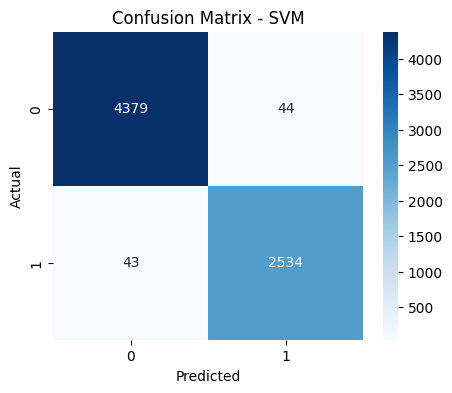

In [36]:
plt.figure(figsize=(5,4))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - SVM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Comparison and Cross Validation

In [37]:
# Model names and metrics
models = ['Logistic Regression', 'SVM']
means = [log_reg_mean, svm_mean]
stds = [log_reg_std, svm_std]

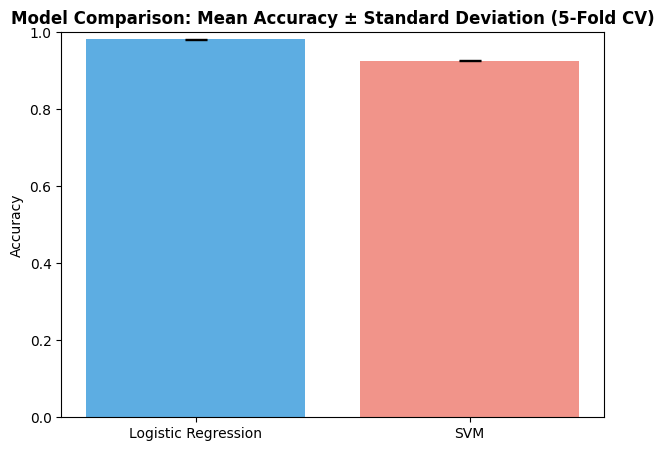

In [38]:
# Plot
plt.figure(figsize=(7, 5))
plt.bar(models, means, yerr=stds, capsize=8, color=['#5DADE2', '#F1948A'])
plt.ylabel('Accuracy')
plt.title('Model Comparison: Mean Accuracy ± Standard Deviation (5-Fold CV)', fontsize=12, fontweight='bold')
plt.ylim(0, 1)
plt.show()

AUC

In [39]:
# Import roc_auc_score
from sklearn.metrics import roc_auc_score, roc_curve


In [40]:
# Logistic Regression AUC
y_pred_prob_log = log_reg.predict_proba(X_test_scaled)[:, 1]
auc_log = roc_auc_score(y_test, y_pred_prob_log)
print(f"Logistic Regression AUC: {auc_log:.4f}")

Logistic Regression AUC: 0.9984


In [41]:
# SVM AUC
y_pred_prob_svm = svm_model.predict_proba(X_test_scaled)[:, 1]
auc_svm = roc_auc_score(y_test, y_pred_prob_svm)
print(f"SVM AUC: {auc_svm:.4f}")

SVM AUC: 0.9995


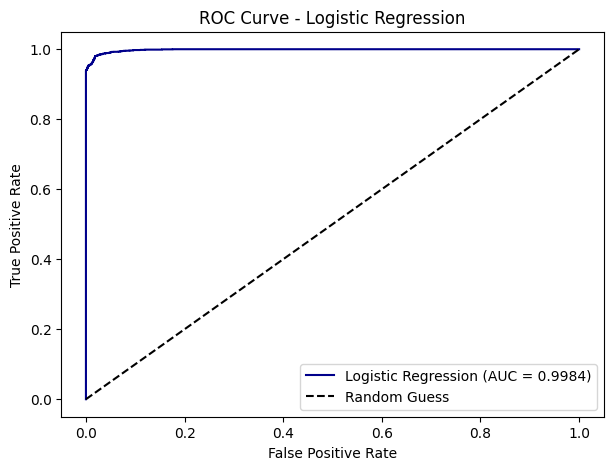

In [48]:
# Plot ROC Curve for Logistic Regression
fpr_log, tpr_log, _ = roc_curve(y_test, y_pred_prob_log)
plt.figure(figsize=(7, 5))
plt.plot(fpr_log, tpr_log, color='darkblue', label=f'Logistic Regression (AUC = {auc_log:.4f})')

# Finalize ROC Curve Plot
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title('ROC Curve - Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

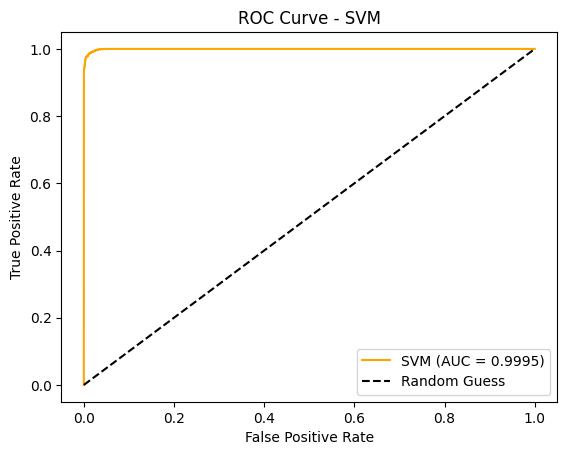

In [49]:
# Plot ROC Curve for SVM
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_pred_prob_svm)
plt.plot(fpr_svm, tpr_svm, color='orange', label=f'SVM (AUC = {auc_svm:.4f})')

# Finalize ROC Curve Plot
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title('ROC Curve - SVM')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()